In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as date
import plotly.express as px
import plotly.graph_objects as go

from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# Dados de 12/01/2021

path = '/content/drive/MyDrive/Colab_Notebooks/BootcampDataScience/modulo_04/painel_covid_12jan2021.csv'
dados = pd.read_csv(path, sep = ';')

In [3]:
dados.head(3)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN


In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641617 entries, 0 to 1641616
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   regiao                  1641617 non-null  object 
 1   estado                  1641293 non-null  object 
 2   municipio               1626440 non-null  object 
 3   coduf                   1641617 non-null  int64  
 4   codmun                  1632572 non-null  float64
 5   codRegiaoSaude          1626440 non-null  float64
 6   nomeRegiaoSaude         1626440 non-null  object 
 7   data                    1641617 non-null  object 
 8   semanaEpi               1641617 non-null  int64  
 9   populacaoTCU2019        1635485 non-null  float64
 10  casosAcumulado          1641617 non-null  int64  
 11  casosNovos              1641617 non-null  int64  
 12  obitosAcumulado         1641617 non-null  int64  
 13  obitosNovos             1641617 non-null  int64  
 14  Re

In [5]:
dados['data'] = pd.to_datetime(dados['data'])

In [6]:
dados.set_index('data',inplace=True)
dados.reset_index(inplace = True)
dados.sort_values('data', inplace = True)
dados['casosPor100k'] = (dados.casosNovos*100000)/dados['populacaoTCU2019']
dados['obitosPor100k'] = (dados.obitosNovos*100000)/dados['populacaoTCU2019']

In [7]:
dados_ufs = dados[dados['municipio'].isnull()].copy()
dados_ufs = dados_ufs[~dados_ufs['estado'].isnull()].copy()
dados_municipios = dados[~dados['municipio'].isnull()].copy()
dados_br  = dados[dados['estado'].isnull()].copy()

# Ao usar o ~ ele representa a negação daquele argumento, então abaixo,
#quando usei o ~ antes do (dados['municipio'].isnull), ao invés de selecionar
#os dados que são NaN, os dados selecionados foram os Não Nulos, o que tem valor. 

In [8]:
print("Entradas DataFrame BR = {};\nEntradas DataFrame UFs = {};\nEntradas DataFrame Municipios = {}.".format(dados_br.shape[0],
                                                                                                              dados_ufs.shape[0],
                                                                                                              dados_municipios.shape[0]))

Entradas DataFrame BR = 324;
Entradas DataFrame UFs = 14853;
Entradas DataFrame Municipios = 1626440.


In [9]:
# Retirada de algumas colunas

dados_br.drop(columns = ['estado', 'municipio','codmun','codRegiaoSaude','nomeRegiaoSaude','interior/metropolitana'],
              inplace = True)

dados_ufs.drop(columns=['municipio','codmun','codRegiaoSaude','Recuperadosnovos','emAcompanhamentoNovos',
                        'nomeRegiaoSaude','interior/metropolitana'], inplace=True)

dados_municipios.drop(columns=['Recuperadosnovos','emAcompanhamentoNovos'], inplace=True)

In [10]:
# Média Mível Brasil

dados_br['mediaMovelCasos7dias'] = dados_br.casosNovos.rolling(7).mean()
dados_br['mediaMovelCasos10dias'] = dados_br.casosNovos.rolling(10).mean()
dados_br['mediaMovelCasos14dias'] = dados_br.casosNovos.rolling(14).mean()

dados_br['mediaMovelObitos7dias'] = dados_br.obitosNovos.rolling(7).mean()
dados_br['mediaMovelObitos10dias'] = dados_br.obitosNovos.rolling(10).mean()
dados_br['mediaMovelObitos14dias'] = dados_br.obitosNovos.rolling(14).mean()

# Casos e óbitos por 100k Habitantes c/ media movel do Br

dados_br['casosPor100k7dias'] = (dados_br.mediaMovelCasos7dias*100000)/dados_br.populacaoTCU2019
dados_br['casosPor100k10dias'] = (dados_br.mediaMovelCasos10dias*100000)/dados_br.populacaoTCU2019
dados_br['casosPor100k14dias'] = (dados_br.mediaMovelCasos14dias*100000)/dados_br.populacaoTCU2019

dados_br['obitosPor100k7dias'] = (dados_br.mediaMovelObitos7dias*100000)/dados_br.populacaoTCU2019
dados_br['obitosPor100k10dias'] = (dados_br.mediaMovelObitos10dias*100000)/dados_br.populacaoTCU2019
dados_br['obitosPor100k14dias'] = (dados_br.mediaMovelObitos14dias*100000)/dados_br.populacaoTCU2019

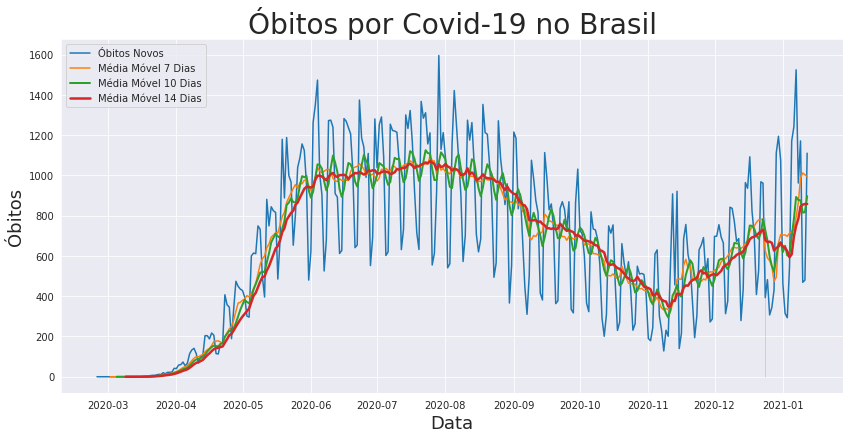

In [11]:
sns.set_style('darkgrid')

# Visualização de Óbitos do Brasil e checagem das médias móveis

plt.figure(figsize=(14,6.5))
sns.lineplot(data=dados_br, x = 'data', y ='obitosNovos')
sns.lineplot(data=dados_br, x = 'data', y ='mediaMovelObitos7dias', lw = 1.5)
sns.lineplot(data=dados_br, x = 'data', y ='mediaMovelObitos10dias', lw = 2)
sns.lineplot(data=dados_br, x = 'data', y ='mediaMovelObitos14dias', lw = 2.5)

plt.legend(['Óbitos Novos', "Média Móvel 7 Dias", "Média Móvel 10 Dias", "Média Móvel 14 Dias"])

plt.title("Óbitos por Covid-19 no Brasil", fontsize = 28)
plt.ylabel("Óbitos", fontsize = 18)
plt.xlabel("Data", fontsize = 18)

plt.show()

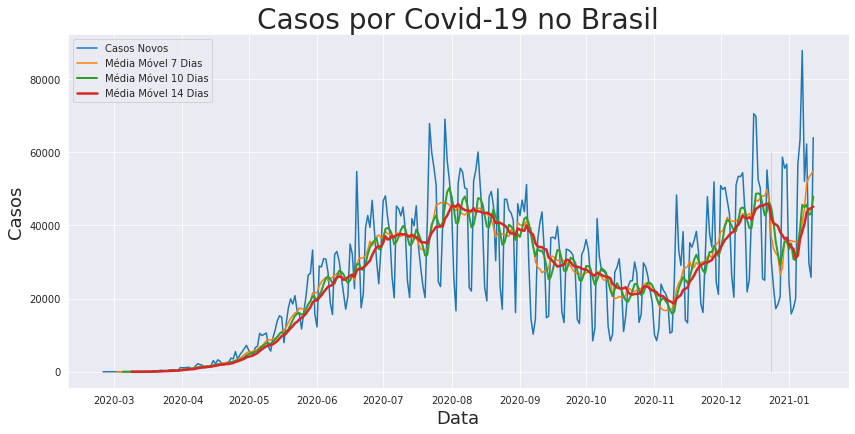

In [12]:
# Visualização de Dados de casos

plt.figure(figsize=(14,6.5))
sns.lineplot(data=dados_br, x = 'data', y ='casosNovos')
sns.lineplot(data=dados_br, x = 'data', y ='mediaMovelCasos7dias', lw = 1.5)
sns.lineplot(data=dados_br, x = 'data', y ='mediaMovelCasos10dias', lw = 2)
sns.lineplot(data=dados_br, x = 'data', y ='mediaMovelCasos14dias', lw = 2.5)

plt.legend(['Casos Novos', "Média Móvel 7 Dias", "Média Móvel 10 Dias", "Média Móvel 14 Dias"])

plt.title("Casos por Covid-19 no Brasil", fontsize = 28)
plt.ylabel("Casos", fontsize = 18)
plt.xlabel("Data", fontsize = 18)

plt.show()

In [13]:
# Média Móvel das UFs de Casos e Óbitos

dados_ufs.sort_values(['coduf','data'], inplace=True)

dados_ufs['mediaMovelCasos7dias'] = list(dados_ufs.sort_values(['data','coduf']).groupby('coduf')['casosNovos'].rolling(7).mean())
dados_ufs['mediaMovelCasos10dias'] = list(dados_ufs.sort_values(['data','coduf']).groupby('coduf')['casosNovos'].rolling(10).mean())
dados_ufs['mediaMovelCasos14dias'] = list(dados_ufs.sort_values(['data','coduf']).groupby('coduf')['casosNovos'].rolling(14).mean())

dados_ufs['mediaMovelObitos7dias'] = list(dados_ufs.sort_values(['data','coduf']).groupby('coduf')['obitosNovos'].rolling(7).mean())
dados_ufs['mediaMovelObitos10dias'] = list(dados_ufs.sort_values(['data','coduf']).groupby('coduf')['obitosNovos'].rolling(10).mean())
dados_ufs['mediaMovelObitos14dias'] = list(dados_ufs.sort_values(['data','coduf']).groupby('coduf')['obitosNovos'].rolling(14).mean())

# Casos e óbitos por 100k Habitantes c/ media movel dos estados

dados_ufs['casosPor100k7dias'] = (dados_ufs.mediaMovelCasos7dias*100000)/dados_ufs.populacaoTCU2019
dados_ufs['casosPor100k10dias'] = (dados_ufs.mediaMovelCasos10dias*100000)/dados_ufs.populacaoTCU2019
dados_ufs['casosPor100k14dias'] = (dados_ufs.mediaMovelCasos14dias*100000)/dados_ufs.populacaoTCU2019

dados_ufs['obitosPor100k7dias'] = (dados_ufs.mediaMovelObitos7dias*100000)/dados_ufs.populacaoTCU2019
dados_ufs['obitosPor100k10dias'] = (dados_ufs.mediaMovelObitos10dias*100000)/dados_ufs.populacaoTCU2019
dados_ufs['obitosPor100k14dias'] = (dados_ufs.mediaMovelObitos14dias*100000)/dados_ufs.populacaoTCU2019

In [14]:
# Média Móvel dos municipios de Casos e Óbitos

dados_municipios.sort_values(['codmun','data'], inplace=True)

dados_municipios['mediaMovelCasos7dias'] = list(dados_municipios.sort_values(['data','codmun']).groupby('codmun')['casosNovos'].rolling(7).mean())
dados_municipios['mediaMovelCasos10dias'] = list(dados_municipios.sort_values(['data','codmun']).groupby('codmun')['casosNovos'].rolling(10).mean())
dados_municipios['mediaMovelCasos14dias'] = list(dados_municipios.sort_values(['data','codmun']).groupby('codmun')['casosNovos'].rolling(14).mean())

dados_municipios['mediaMovelObitos7dias'] = list(dados_municipios.sort_values(['data','codmun']).groupby('codmun')['obitosNovos'].rolling(7).mean())
dados_municipios['mediaMovelObitos10dias'] = list(dados_municipios.sort_values(['data','codmun']).groupby('codmun')['obitosNovos'].rolling(10).mean())
dados_municipios['mediaMovelObitos14dias'] = list(dados_municipios.sort_values(['data','codmun']).groupby('codmun')['obitosNovos'].rolling(14).mean())

# Casos e óbitos por 100k Habitantes c/ media movel dos municipios

dados_municipios['casosPor100k7dias'] = (dados_municipios.mediaMovelCasos7dias*100000)/dados_municipios.populacaoTCU2019
dados_municipios['casosPor100k10dias'] = (dados_municipios.mediaMovelCasos10dias*100000)/dados_municipios.populacaoTCU2019
dados_municipios['casosPor100k14dias'] = (dados_municipios.mediaMovelCasos14dias*100000)/dados_municipios.populacaoTCU2019

dados_municipios['obitosPor100k7dias'] = (dados_municipios.mediaMovelObitos7dias*100000)/dados_municipios.populacaoTCU2019
dados_municipios['obitosPor100k10dias'] = (dados_municipios.mediaMovelObitos10dias*100000)/dados_municipios.populacaoTCU2019
dados_municipios['obitosPor100k14dias'] = (dados_municipios.mediaMovelObitos14dias*100000)/dados_municipios.populacaoTCU2019


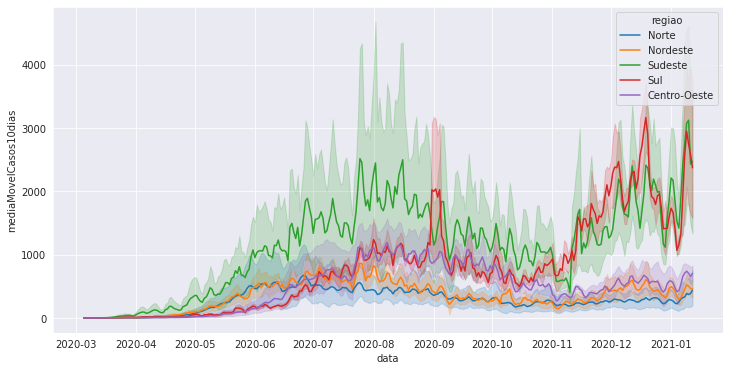

In [15]:
# Média Móvel de Casos de 10 dias por Região

plt.figure(figsize=(12,6))
sns.lineplot(data=dados_ufs, x = 'data', y ='mediaMovelCasos10dias', hue = 'regiao')

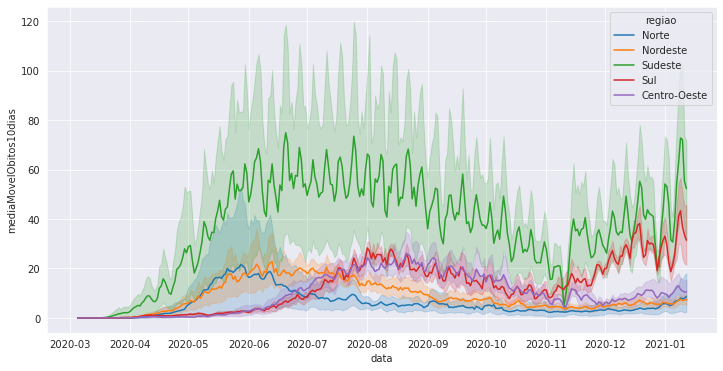

In [16]:
# Média Móvel de Óbitos por 10 dias por região

plt.figure(figsize=(12,6))
sns.lineplot(data=dados_ufs, x = 'data', y ='mediaMovelObitos10dias', hue = 'regiao')

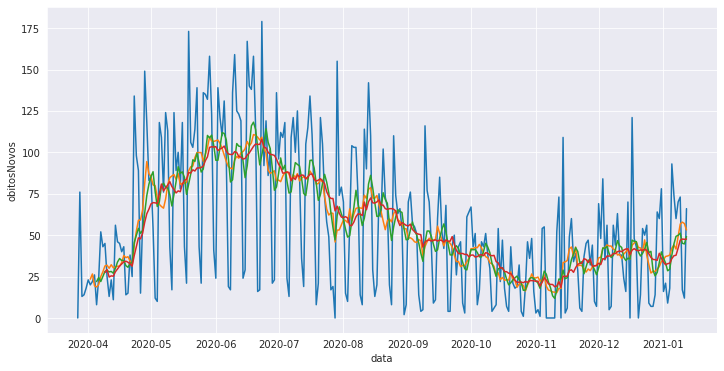

In [23]:
plt.figure(figsize=(12,6))
sns.lineplot(data=dados_municipios[dados_municipios['municipio'] == "São Paulo"],
             x = 'data', y = 'obitosNovos')
sns.lineplot(data=dados_municipios[dados_municipios['municipio'] == "São Paulo"],
             x = 'data', y = 'mediaMovelObitos7dias')
sns.lineplot(data=dados_municipios[dados_municipios['municipio'] == "São Paulo"],
             x = 'data', y = 'mediaMovelObitos10dias')
sns.lineplot(data=dados_municipios[dados_municipios['municipio'] == "São Paulo"],
             x = 'data', y = 'mediaMovelObitos14dias')

plt.show()

In [68]:
fig = px.line(dados_br,x = 'data',y='mediaMovelCasos7dias')
fig.add_bar(x = dados_br['data'],y=dados_br['casosNovos'], name = "Casos Novos") 
fig

In [69]:
fig = px.line(dados_br,x = 'data',y='mediaMovelObitos7dias')
fig.add_bar(x = dados_br['data'],y=dados_br['obitosNovos'],
            hoverinfo=['all'], hovertext=('x','y'), name = "Obitos Novos")
fig
